# Analyzing Tumor Percentage per Volume vs Model Performance

![CT Image](https://storage.googleapis.com/kaggle-datasets-images/674071/1185670/0d449dc88ac1318321ae8f7de974f0fa/dataset-cover.jpg?t=2020-05-25-13-21-33)

- **Author:** *Mariusz Wiśniewski*
- **Date created:** *May 4th, 2023*
- **Last modified:** *May 4th, 2023*

## Overview

This notebook shows how to analyze the relationship between the percentage of the volume that is occupied by the tumor and the performance of the model.

# Notebook Setup

## Import Statements

In [61]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dotenv import load_dotenv
from tensorflow.keras import Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("deep")

## Loading the Environmental Variables

In [62]:
load_dotenv()

True

## Project Configuration

In [63]:
config = {
    'test_batch_size': 1,
    'img_size': 240,
    'depth': 155,
    'n_classes': 2,
    'fold': 4,
}

# Dataset

BraTS2020 is a medical imaging challenge. The goal is to segment the tumor from the brain MRI scans. The dataset is available on [Kaggle](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data).

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe:

- native (**T1**),
- post-contrast T1-weighted (**T1Gd**),
- T2-weighted (**T2**),
- T2 Fluid Attenuated Inversion Recovery (**T2-FLAIR**)

volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise:

- the necrotic and non-enhancing tumor core (**NCR/NET — label 1**),
- the peritumoral edema (**ED — label 2**),
- the GD-enhancing tumor (**ET — label 4**),
 
as described both in the [BraTS 2012-2013 TMI paper](https://ieeexplore.ieee.org/document/6975210) and in the [latest BraTS summarizing paper](https://arxiv.org/abs/1811.02629). The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution ($1 {mm}^3$) and skull-stripped.

## Class Distribution

In [64]:
BASE_PATH = '.'
MODEL = '3D_CNN'
DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'seg']
CLASS_NAMES = ['normal', 'tumor']
df = pd.read_csv(f'{BASE_PATH}/metadata.csv')
print(df['label'].value_counts())

label
1    575
0    163
Name: count, dtype: int64


In [65]:
df.head()

,volume_id,path,label,half,fold
0,1,data/BraTS20_Training_001/left,1,left,3
1,1,data/BraTS20_Training_001/right,1,right,1
2,2,data/BraTS20_Training_002/left,0,left,2
3,2,data/BraTS20_Training_002/right,1,right,0
4,3,data/BraTS20_Training_003/left,1,left,3


## Building the Test Set

In [66]:
labels = np.array(df['label'])
paths = np.array(df['path'])
train_indices = df[df['fold'] != config['fold']].index.values.tolist()
test_indices = df[df['fold'] == config['fold']].index.values.tolist()
assert set(train_indices).isdisjoint(test_indices)

print(
    'Number of samples:\n'
    f'train: {len(train_indices)} ({round(float(len(train_indices)) / float(len(labels)) * 100.0)}% of the dataset)\n'
    f'test: {len(test_indices)} ({round(float(len(test_indices)) / float(len(labels)) * 100.0)}% of the dataset)'
)

Number of samples:
train: 590 (80% of the dataset)
test: 148 (20% of the dataset)


## Data Generator

In [67]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, indices, paths, labels, batch_size=4, dim=(240, 120, 155),
                 n_classes=2, shuffle=True, transform=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths
        self.labels = labels
        self.indices = indices
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        indices_temp = [self.indices[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indices_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, len(DATA_TYPES[:-1])))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indices_temp):
            # Store sample
            vol_path = [
                path for path in glob(f'{BASE_PATH}/{self.paths[ID]}/*.npz') if not 'seg' in path
            ][0]
            volume = np.load(vol_path)['data']
            volume = (volume.astype('float32') / 255.0).astype('float32')

            if self.transform is not None:
                volume = self.transform(**{'image': volume})['image']
            X[i,] = volume

            # # Store class
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [68]:
test_generator = DataGenerator(
    test_indices,
    paths,
    labels,
    batch_size=config['test_batch_size'],
    dim=(config['img_size'], config['img_size'] // 2, config['depth']),
    shuffle=False,
)

# Model Performance Analysis

## Loading the Model

In [69]:
model = tf.keras.models.load_model(
    f'{MODEL}/fold{config["fold"]}/best{config["fold"]}.h5'
)

## Performance Evaluation

In [70]:
y_pred = [np.argmax(x) for x in model.predict(
    test_generator, batch_size=config['test_batch_size'])]
y_test = [labels[idx] for idx in test_indices]

correctly_classified = np.array(y_pred) == np.array(y_test)
print(
    f'Accuracy: {(np.sum(correctly_classified) / len(correctly_classified)) * 100.0:.2f}%')

2023-05-12 13:51:51.879844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - 26s 172ms/step
Accuracy: 74.32%


## Examining Tumor Percentage per Volume

In [71]:
percentages = []
for idx in test_indices:
    seg_path = [
        path for path in glob(f'{BASE_PATH}/{paths[idx]}/*.npz') if 'seg' in path
    ][0]
    seg = np.load(seg_path)['data']
    percentages.append((np.sum(seg) / np.prod(seg.shape)) * 100.0)

percentages = np.array(percentages)

In [72]:
# save percentages as npy
np.save(f'percentages{config["fold"]}.npy', percentages)
# save correctly_classified as npy
np.save(f'correctly_classified{config["fold"]}.npy', correctly_classified)

## Analyzing the Relationship Between Tumor Percentage per Volume and Model Performance

In [88]:
# now we can load them all, and plot them
percentages = None
correctly_classified = None
for fold in range(5):
    if percentages is None:
        percentages = np.load(f'percentages{fold}.npy')
        correctly_classified = np.load(f'correctly_classified{fold}.npy')
    else:
        percentages = np.concatenate((percentages, np.load(f'percentages{fold}.npy')))
        correctly_classified = np.concatenate((correctly_classified, np.load(f'correctly_classified{fold}.npy')))

In [89]:
percentages.shape, correctly_classified.shape

((738,), (738,))

In [ ]:
# save percentages as npy
np.save(f'percentages.npy', percentages)
# save correctly_classified as npy
np.save(f'correctly_classified.npy', correctly_classified)

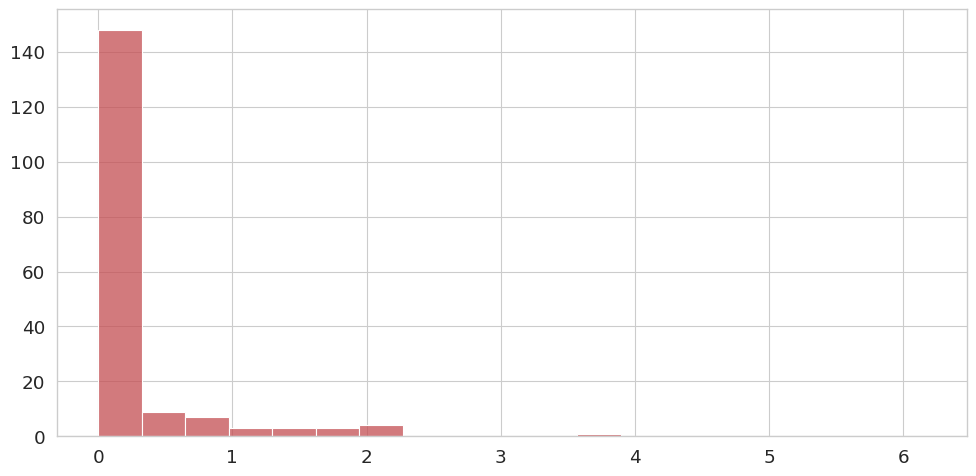

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
# makse the bins of the same size
bins = np.linspace(0, np.max(percentages[correctly_classified]), 20)
# plt.grid(False)
# plt.axis('off')
# plt.tight_layout()
# plt.xaxis.label.set_visible(False)
# hide axis title
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_label('')


# h1 = sns.histplot(
#     percentages[correctly_classified],
#     bins=bins,
#     color=sns.color_palette()[2],
#     label='Correctly classified',
#     ax=ax,
# )
# set font to courier new
# plt.rcParams["font.family"] = "Courier"
h1 = sns.histplot(
    percentages[~np.array(correctly_classified)],
    bins=bins,
    color=sns.color_palette()[3],
    label='Incorrectly classified',
    ax=ax,
)
h1.set(ylabel=None)
# ax.set_xlabel('Tumor percentage')
# ax.set_ylabel('Number of samples')
# ax.legend()
# plt.title('Influence of tumor percentage on classification accuracy')
plt.tight_layout()

## Removing Samples with the Lowest Tumor Percentage per Volume

In [74]:
# remove the test indices where the tumor percentage is in the lowest 10%
# percentile = 10
# correctly_classified = correctly_classified[percentages > np.percentile(
#     percentages, percentile)]

In [75]:
# accuracy = np.sum(correctly_classified) / len(correctly_classified)
# print(f'Accuracy: {accuracy * 100.0:.2f}%')